In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#from tqdm import tqdm
from causal_ccm.causal_ccm import ccm

In [6]:
df = pd.read_csv('C:/Users/1evsa/Desktop/M/proj/rootanalysis/dados/Mock_dataset/MockDataset_train.csv')
df

,GroupKey,PrimaryKey,RelationKey,RelationType,Date,Value,DerivedFlag,DerivedLag,DerivedType
0,A1,A1,A,ROOT,2020-01-01,41.0,NaN,NaN,none
1,A1,A1,A,ROOT,2020-01-02,36.0,NaN,NaN,none
2,A1,A1,A,ROOT,2020-01-03,34.0,NaN,NaN,none
3,A1,A1,A,ROOT,2020-01-04,38.0,NaN,NaN,none
4,A1,A1,A,ROOT,2020-01-05,30.0,NaN,NaN,none
...,...,...,...,...,...,...,...,...,...
10145,G1,G29,G1,RELATED,2020-02-15,4.0,0.0,NaN,none
10146,G1,G29,G1,RELATED,2020-02-16,5.0,0.0,NaN,none
10147,G1,G29,G1,RELATED,2020-02-17,4.0,0.0,NaN,none
10148,G1,G29,G1,RELATED,2020-02-18,4.0,0.0,NaN,none


In [10]:
df['Date'] = df['Date'].str.replace('-', '')
df_res = pd.DataFrame()
groups = pd.unique(df['GroupKey'])
rs = {}
for group in groups:
    gr = df[df['GroupKey']==group]
    pks = pd.unique(gr['PrimaryKey'])
    res = {}
    root = df[df['PrimaryKey']==group]['Value']
    Y = root.tolist()
    for key in pks[1:]:
        rel=df[df['PrimaryKey']==key]['Value']
        flag = df.loc[(df['PrimaryKey'] == key),'DerivedFlag'].values[0]
        X = rel.tolist()
        E = 2 
        L = len(X)
        max_s = 0
        p=0
        lag = None
        #res = {'strength': max_s, 'p-value': p, 'lag': lag, 'flag': flag}
        for tau in range(1,15):
            ccm1 = ccm(X, Y, tau, E, L)
            ccm2 = ccm1.causality()
            
            if ccm2[0]>max_s:
                max_s=ccm2[0]
                p=ccm2[1]
                lag=tau
            
        res[key] = {'score': max_s, 'p-value': p, 'lag': lag, 'flag': flag}
    df_res = pd.concat([df_res, pd.DataFrame.from_dict(res, orient='index')])
    #rs[group] = res
df_res

,score,p-value,lag,flag
A2,0.864359,2.709311e-12,12,1.0
A3,0.888898,1.741720e-15,7,1.0
A4,0.931006,1.155175e-18,9,1.0
A5,0.882795,2.280079e-14,9,1.0
A6,0.879871,3.587596e-14,9,1.0
...,...,...,...,...
G25,0.723777,8.928659e-08,9,0.0
G26,0.840852,3.928065e-11,12,0.0
G27,0.825228,1.031180e-10,11,0.0
G28,0.894225,5.806382e-17,4,0.0


In [13]:
def conf_m_analysis(df, thresholds, m):
    metrics = []
    for threshold in range(1,20):
        df['prediction'] = df['prediction'] = 0
        df.loc[df['score'] > threshold, ['prediction']] = 1
        conf_m = pd.crosstab(df['flag'], df['prediction'])

In [15]:
thresholds = range(1,20)
tests = []
tests += conf_m_analysis(df_res, thresholds, 'ssr_ftest')

t = pd.DataFrame(tests)
print(t.sort_values(by=['f1-score'], ascending=False))

TypeError: 'NoneType' object is not iterable

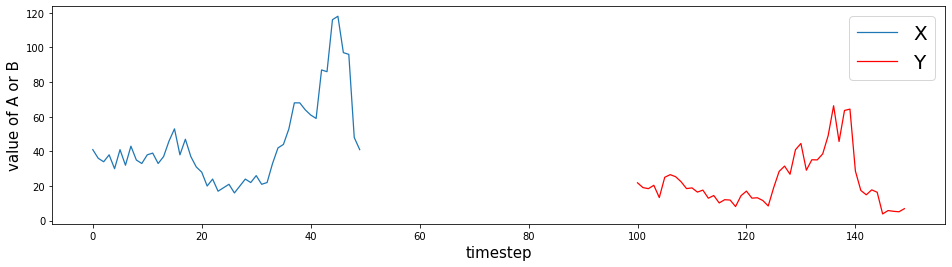

In [8]:
dfA1=df[df['PrimaryKey']=='A1'][['Date','Value']]
dfA2=df[df['PrimaryKey']=='A3'][['Date','Value']]
A=dfA1['Value']
B=dfA2['Value']

plt.figure(figsize=(16,4))
max_t = 100
plt.plot(A[:max_t], linewidth=1.25, label='X')
plt.plot(B[:max_t], c='r', linewidth=1.25, label='Y')
plt.xlabel('timestep', size=15)
plt.ylabel('value of A or B', size=15)
plt.legend(prop={'size': 20})

In [9]:
A_list=A.tolist()
B_list=B.tolist()

In [10]:
tau = 7 # time lag
E = 2 # shadow manifold embedding dimensions
L = len(B_list) # length of time period to consider
ccm1 = ccm(B_list, A_list, tau, E, L)
ccm1.causality()

(0.8888979798428334, 1.7417201628898685e-15)

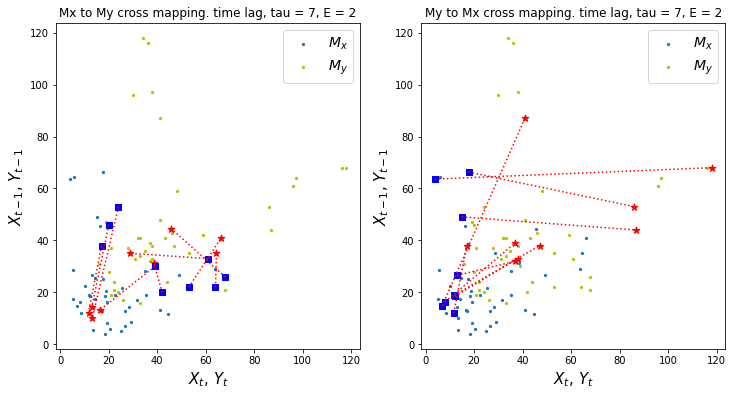

In [11]:
ccm1.visualize_cross_mapping()

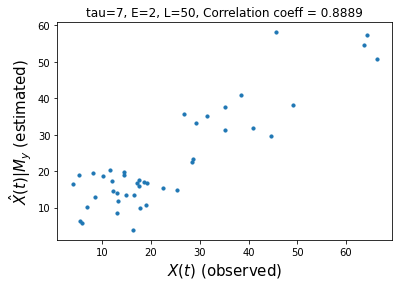

In [12]:
ccm1.plot_ccm_correls()

In [13]:
# checking convergence
# Looking at "convergence"
L_range = range(50, 3000, 200) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in tqdm(L_range): 
    ccm_XY = ccm(B_list, A_list, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(A_list,B_list, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, c='r', label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=15)
plt.ylabel('correl', size=15)
plt.legend(prop={'size': 20})

  7%|▋         | 1/15 [00:00<00:00, 118.13it/s]


IndexError: list index out of range